In [1]:
import pandas as pd
from citipy import citipy
import numpy as np
import csv
from datetime import datetime as dt, timedelta
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import gmaps 
from config import gkey


#import data
weather = pd.read_json("ow.json") #1/1/2013-1/1/2020 hourly weather data
crime = pd.read_csv("../../crime.csv")

In [2]:
#Drop unneeded columns
drop_list = ['GEO_X', 'GEO_Y', 'DISTRICT_ID', 
             'REPORTED_DATE', 'LAST_OCCURRENCE_DATE',
            'INCIDENT_ID', 'OFFENSE_ID', 'OFFENSE_CODE_EXTENSION']
crime.drop(columns=drop_list, inplace=True)



In [3]:
#Clean up column names
crime = crime.rename(columns = {'OFFENSE_CODE':'Code', 
                               'OFFENSE_TYPE_ID':'Offense_Type', 
                               'INCIDENT_ADDRESS':'Address', 
                               'GEO_LON':'Lon',
                               'GEO_LAT':'Lat', 
                               'PRECINCT_ID':'Precint', 
                               'NEIGHBORHOOD_ID':'Neighborhood'})

# remove incorrect lat longs skewing data
crime = crime[crime["Lon"] <= -104.2]
crime = crime[crime["Lon"] >= -105.5]
crime = crime[crime["Lat"] >= 39.5]
crime = crime[crime["Lat"] <= 40.0]

In [4]:
#expand list from columns into new databases
weather_temp = (json_normalize(weather['main']))
weather_wind = json_normalize(weather['wind'])
weather_clouds = json_normalize(weather['clouds'])


In [5]:
#create new columns for desired fields from expanded list
weather_temp.head()
weather['Temp'] = weather_temp['temp']
weather['Temp Max'] = weather_temp['temp_max']
weather['Wind'] = weather_wind.speed
weather['Clouds'] = weather_clouds

#early round about way of cleaning up date
#split date iso into columns, then delete unwanted columns 
weather[['Date','Hour', 'Trash', 'Trash2']] = weather.dt_iso.str.split(expand=True)
columns = ['wind', 'clouds', 'weather','main', 'timezone', 'snow', 'rain', 'dt', 'Trash', 'Trash2', 'dt_iso', 'lat', 'lon']
weather.drop(columns=columns, inplace=True)
weather['Date & Time'] = weather['Date'] + ' ' + weather['Hour']
weather['Date & Time'] = weather['Date & Time'].astype('datetime64[ns]')
weather = weather.drop(columns =['Date', 'Hour'])
weather = weather.rename(columns = {'Date & Time':'Date'})

In [6]:
crime['Date'] = pd.to_datetime(crime['FIRST_OCCURRENCE_DATE'])
crime.drop(columns=['FIRST_OCCURRENCE_DATE'], inplace=True)
crime['Date'] = crime['Date'].dt.round('60min')


In [7]:
#merge crime and weather data
crime_weather = pd.merge(crime, weather, on='Date', how='left')


In [8]:
#clean up crim offense categories
crime_weather = crime_weather[crime_weather["OFFENSE_CATEGORY_ID"] != 'all-other-crimes']

crime_weather['OFFENSE_CATEGORY_ID'] = crime_weather['OFFENSE_CATEGORY_ID'].replace(
    {'traffic-accident': 'Traffic Accident', 
     'larceny': 'Burglary/Theft', 
     'public-disorder': 'Public Disorder', 
     'theft-from-motor-vehicle': 'Burglary/Theft', 
     'drug-alcohol': 'Drug/Alcohol', 
     'auto-theft': 'Burglary/Theft', 
     'burglary': 'Burglary/Theft', 
     'other-crimes-against-persons': 'Crimes Against Persons', 
     'aggravated-assault': 'Aggravated Assault', 
     'white-collar-crime': 'White Collar Crime',  
     'robbery': 'Burglary/Theft', 
     'arson': 'Arson', 
     'murder': 'Murder'})
print(".........................................")
print(crime_weather["OFFENSE_CATEGORY_ID"].value_counts())

.........................................
Burglary/Theft            137443
Traffic Accident          120249
Public Disorder            46520
Drug/Alcohol               29436
Crimes Against Persons     22754
Aggravated Assault         11330
White Collar Crime          6408
Arson                        547
Murder                       300
Name: OFFENSE_CATEGORY_ID, dtype: int64


In [9]:
#write new master database to csv
crime_weather.to_csv('crime_weather.csv')

In [54]:
#seperate data into crime dataframe and traffic datafram
is_crime = crime_weather.loc[crime_weather['IS_CRIME'] == 1]
is_traffic = crime_weather.loc[crime_weather['IS_TRAFFIC'] == 1]

#drop dates from weather for before earliest crime data entry
#use this dataframe to standardize data
weather = weather.loc[weather['Date'] > '2015-01-02 00:00:00']


In [57]:
#bin crime, traffic and weather data 
bins = [-10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
groups = ['-10-0', '0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '100-110']
is_crime['Temp Range'] = pd.cut(is_crime["Temp"], bins, labels=groups)
is_traffic['Temp Range'] = pd.cut(is_traffic["Temp"], bins, labels=groups)
weather['Temp Range'] = pd.cut(weather["Temp"].round(), bins, labels=groups)

#set new index and drop na
is_crime.set_index('Temp Range', inplace=True)
is_traffic.set_index('Temp Range', inplace=True)
weather.set_index('Temp Range', inplace=True)
weather.sort_index(inplace=True)
weather.dropna(inplace=True)

C:\Users\Deepak\Anaconda\envs\PythonData\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Deepak\Anaconda\envs\PythonData\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [12]:
#groupby Neighborhood and set weight for heatmap = count of crimes within neighboorhood
groupn_mean_df = crime_weather.groupby("Neighborhood").mean()
count  = crime_weather.groupby("Neighborhood").count()['IS_CRIME'].astype(float)

#set locations equal to neighborhood lat and lon
locations = groupn_mean_df[["Lat", "Lon"]].astype(float)

In [13]:
#map crime in denver
gmaps.configure(api_key=gkey)
fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations, weights=count, max_intensity=10000,
                                 point_radius = 15)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [88]:
##standardize data 

Ctemp_Plot = is_crime.groupby('Temp Range').count()
Ttemp_Plot = is_traffic.groupby('Temp Range').count()
weather_Count = weather.groupby('Temp Range').count()
#Ctemp_Plot = Ctemp_Plot.drop('100-110')
#Ttemp_Plot = Ttemp_Plot.drop('100-110')
Cstandardize = Ctemp_Plot['Code'] / weather_Count['Temp']
Tstandardize = Ttemp_Plot['Code'] / weather_Count['Temp']

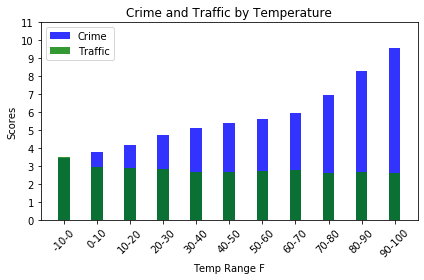

<Figure size 432x288 with 0 Axes>

In [89]:
#create bar chart containing crime and traffic by temp
fig, ax = plt.subplots()
bar_width = 0.35
opacity = 0.8

crime = plt.bar(Cstandardize.index, Cstandardize, bar_width,
alpha=opacity,
color='b',
label='Crime')

traffic = plt.bar(Tstandardize.index, Tstandardize, bar_width,
alpha=opacity,
color='g',
label='Traffic')

plt.xlabel('Temp Range F')
plt.ylabel('Scores')
plt.title('Crime and Traffic by Temperature')
plt.xticks(rotation = '45')
plt.yticks(range(0,12))
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

#save to png
plt.savefig("crime and traffic temp.png")

In [90]:
#create bins for Wind Ranges for Weather, Crime and traffic databases
bins = [0, 10, 20, 30, 40, 51]
groups = ['0-10', '10-20', '20-30', '30-40', '40-50']
is_crime['Wind Range'] = pd.cut(is_crime["Wind"].round(), bins, labels=groups)

bins = [0, 10, 20, 30, 40, 51]
groups = ['0-10', '10-20', '20-30', '30-40', '40-50']
is_traffic['Wind Range'] = pd.cut(is_traffic["Wind"].round(), bins, labels=groups)

bins = [0, 10, 20, 30, 40, 51]
groups = ['0-10', '10-20', '20-30', '30-40', '40-50']
weather['Wind Range'] = pd.cut(weather["Wind"].round(), bins, labels=groups)


C:\Users\Deepak\Anaconda\envs\PythonData\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Deepak\Anaconda\envs\PythonData\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [91]:
#set new index to Wind Range
is_crime = is_crime.set_index('Wind Range')
weather = weather.set_index('Wind Range')
is_traffic = is_traffic.set_index('Wind Range')

In [92]:
#set variables and standardize data
Cwind_Count = is_crime.groupby('Wind Range').count()
Wwind_Count = weather.groupby('Wind Range').count()
Cwind_stand = Cwind_Count['Temp'] / Wwind_Count['Temp']

Twind_Count = is_traffic.groupby('Wind Range').count()
Twind_stand = Twind_Count['Temp'] / Wwind_Count['Temp']

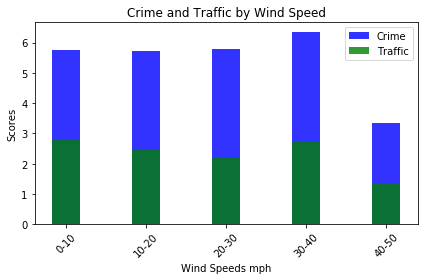

<Figure size 432x288 with 0 Axes>

In [93]:
#bar chart crime and traffic by wind
fig, ax = plt.subplots()
bar_width = 0.35
opacity = 0.8

crime = plt.bar(Cwind_stand.index, Cwind_stand, bar_width,
alpha=opacity,
color='b',
label='Crime')

traffic = plt.bar(Twind_stand.index, Twind_stand, bar_width,
alpha=opacity,
color='g',
label='Traffic')

plt.xlabel('Wind Speeds mph')
plt.ylabel('Scores')
plt.title('Crime and Traffic by Wind Speed')
plt.xticks(rotation = '45')
plt.legend()

plt.tight_layout()
plt.show()

#save fig to png
plt.savefig("crime and traffic wind.png")

In [94]:
is_crime.reset_index(inplace = True) 
weather.reset_index(inplace = True) 

In [ ]:
#isolate seasons, needs more work
years = ['2016', '2017', '2018', '2019']
summer1C = is_crime.loc[(is_crime['Date'] > '2015-06-01 00:00:00') & (is_crime['Date'] < '2015-09-01 00:00:00')]
#winter15 = is_crime.loc[(is_crime['Date'] > '2015-12-01 00:00:00') & (is_crime['Date'] < '2015-03-01 00:00:00')]
fall1C = is_crime.loc[(is_crime['Date'] > '2015-09-02 00:00:00') & (is_crime['Date'] < '2015-11-30 00:00:00')]
spring1C = is_crime.loc[(is_crime['Date'] > '2015-03-02 00:00:00') & (is_crime['Date'] < '2015-06-01 00:00:00')]
summer1W = is_crime.loc[(weather['Date'] > '2015-06-01 00:00:00') & (weather['Date'] < '2015-09-01 00:00:00')]
fall1W = is_crime.loc[(weather['Date'] > '2015-09-02 00:00:00') & (weather['Date'] < '2015-11-30 00:00:00')]
spring1W = is_crime.loc[(weather['Date'] > '2015-03-02 00:00:00') & (weather['Date'] < '2015-06-01 00:00:00')]

for year in years:
    summer = is_crime.loc[(is_crime['Date'] > year + '-06-01 00:00:00') & (is_crime['Date'] < year +'-09-01 00:00:00')]
    fall = is_crime.loc[(is_crime['Date'] > year + '-09-02 00:00:00') & (is_crime['Date'] < year + '-11-30 00:00:00')]
    spring = is_crime.loc[(is_crime['Date'] > year + '-03-02 00:00:00') & (is_crime['Date'] < year + '-06-01 00:00:00')]
    summer1 = is_crime.loc[(weather['Date'] > year + '-06-01 00:00:00') & (weather['Date'] < year + '-09-01 00:00:00')]
    fall1 = is_crime.loc[(weather['Date'] > year + '-09-02 00:00:00') & (weather['Date'] < year + '-11-30 00:00:00')]
    spring1 = is_crime.loc[(weather['Date'] > year + '-03-02 00:00:00') & (weather['Date'] < year + '-06-01 00:00:00')]
    summer1C.merge(summer,  how='outer')
    spring1C.merge(spring, how='outer')
    fall1C.merge(fall, how='outer')
    summer1W.merge(summer1,  how='outer')
    spring1W.merge(spring1, how='outer')
    fall1W.merge(fall1, how='outer')

In [ ]:
##standardize data for seasons
CStemp_Plot = summer1C.groupby('Temp Range').count()
CFtemp_Plot = fall1C.groupby('Temp Range').count()
CSptemp_Plot = spring1C.groupby('Temp Range').count()

WS_Count = summer1W.groupby('Temp Range').count()
WF_Count = fall1W.groupby('Temp Range').count()
WSp_Count = spring1W.groupby('Temp Range').count()
CSstand = CStemp_Plot['Temp'] / WS_Count['Temp']
CFstand = CFtemp_Plot['Temp'] / WF_Count['Temp']
CSpstand = CSptemp_Plot['Temp'] / WSp_Count['Temp']

CStemp_Plot
WS

